## Design domain and make bathymetry input file

**Under construction**

* Select fjord region
* Rotate and convert to cartesian coordinates.
* Fill surronding fjords with the numerical shovel.
* Smoothen bathymetry
* Flatten open boundary

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from netCDF4 import Dataset
import numpy as np
import seaborn as sns

In [2]:
# Load bathy data
filename = "../beru_2022.nc"
nc = Dataset(filename, "r")
#nc

In [3]:
# Get lat, lon and elevation
elev = nc["elevation"][:]
lat = nc["latitude"][:]
lon = nc["longitude"][:]

### Select fjord region for domain

The indices for the yellow box are: x1=470, x2=920, y1=610, y2=765


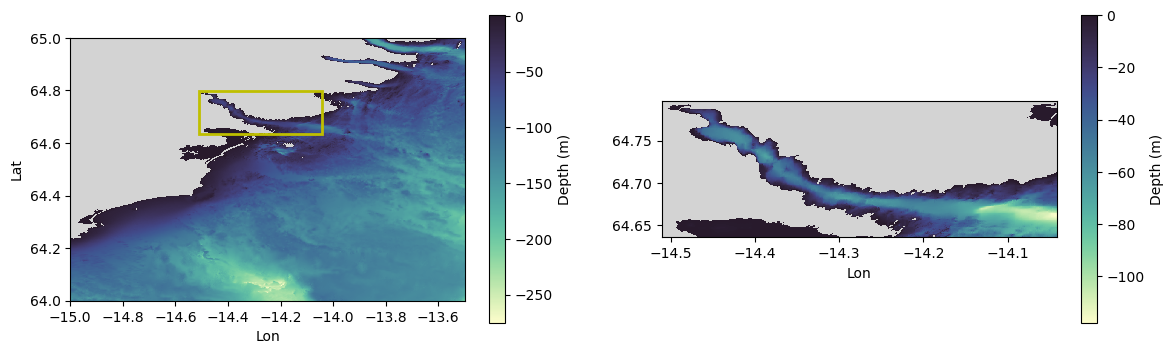

In [33]:
# Plot bathy data
fig, (ax,ax2) = plt.subplots(1,2, figsize=(14,4))
ax.set_facecolor("lightgray")
ax2.set_facecolor("lightgray")

## Plot all data
pc = ax.pcolormesh(lon,lat,elev, cmap=cmo.cm.deep)
plt.colorbar(pc, ax=ax, label= "Depth (m)")

## Select and plot domain
inix = 470
iniy = 610
dx = 450
dy = 155
endx = inix + dx
endy = iniy + dy
w_lon = lon[endx] - lon[inix]
h_lat = lat[endy] - lat[iniy]

pc2 = ax2.pcolormesh(lon[inix:endx],lat[iniy:endy],elev[iniy:endy, inix:endx], cmap=cmo.cm.deep)
plt.colorbar(pc2, ax=ax2, label= "Depth (m)")
# Draw region of interest in ax to check location
ax.add_patch(Rectangle((lon[inix], lat[iniy]), w_lon, h_lat, #((origin), w, h)
                       ec = "y", 
                       fill = False, 
                       lw = 2)) 
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax2.set_xlabel("Lon")
ax.set_aspect(1)
ax2.set_aspect(1)
print(f"The indices for the yellow box are: x1={inix}, x2={endx}, y1={iniy}, y2={endy}")
plt.show()

yellow square: domain on the right panel.

In [34]:
# Domain:
lon_dom, lat_dom, elev_dom = lon[inix:endx],lat[iniy:endy],elev[iniy:endy, inix:endx]

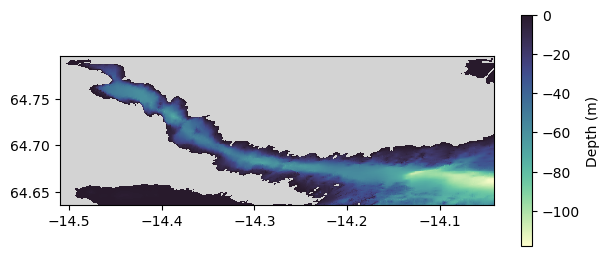

In [35]:
# Plot bathy data
fig, ax = plt.subplots(1,1, figsize=(7,3))
ax.set_facecolor("lightgray")

## Plot all data
pc = ax.pcolormesh(lon_dom,lat_dom,elev_dom, cmap=cmo.cm.deep)
plt.colorbar(pc, ax=ax, label= "Depth (m)")
# Draw region of interest
ax.set_aspect(1)
plt.show()

Those are some bad open boundaries (S and E). I could add an artificial island at the SE corner, or rotate this thing to have only one OB.

### Rotate fjord
First, this is a tiny portion of Earth so I'll make everything distances (x, y), not angles (lat, lon). Then I'll rotate x and y.

In [41]:
def distance(lat1,lon1,lat2,lon2):
    '''Get distance using Haversine formula'''
    r = 6371 #radius of Earth (KM)
    p = np.pi/180  #Pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p)*np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p)) / 2
    d = 2 * r * np.arcsin(np.sqrt(a)) #2*R*asin In km
    return d
def cartesian(longitude, latitude):   
    lon = np.deg2rad(longitude)
    lat = np.deg2rad(latitude)
    R = 6378137.0 #+ elevation, but not for this. relative to centre of the earth
    X = R * np.cos(lon) * np.cos(lat)    
    Y = R * np.sin(lon) * np.cos(lat)
    return X, Y

In [106]:
LON, LAT = np.meshgrid(360+lon_dom,lat_dom)
Xno_o, Yno_o = cartesian(LON,LAT)

# Move near origin
X, Y = Xno_o - Xno_o[0,0], Yno_o - Yno_o[0,0]

# Rotate to line up up with x and y (trial and error)
theta = -75.5
X_rot = X*np.cos(np.deg2rad(theta)) - Y*np.sin(np.deg2rad(theta))
Y_rot = X*np.sin(np.deg2rad(theta)) + Y*np.cos(np.deg2rad(theta))

/tmp/ipykernel_6932/51613904.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc2 = ax2.pcolormesh(X_rot,Y_rot, elev_dom, cmap=cmo.cm.deep)


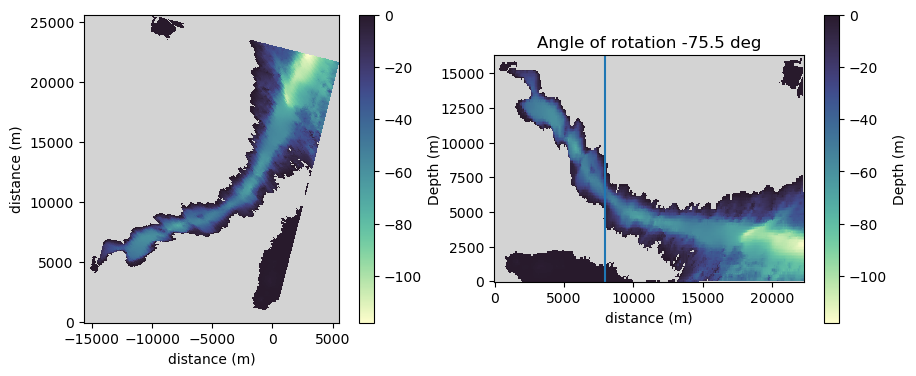

In [107]:
# Plot bathy data
fig, (ax,ax2) = plt.subplots(1,2, figsize=(11,4))
ax.set_facecolor("lightgray")
ax2.set_facecolor("lightgray")

## Plot domain in cartesian - original
pc = ax.pcolormesh(X,Y,elev_dom, cmap=cmo.cm.deep)
plt.colorbar(pc, ax=ax, label= "Depth (m)")
ax.set_aspect(1)
ax.set_xlabel( 'distance (m)')
ax.set_ylabel( 'distance (m)')

## Plot rotated domain 
pc2 = ax2.pcolormesh(X_rot,Y_rot, elev_dom, cmap=cmo.cm.deep)
plt.colorbar(pc2, ax=ax2, label= "Depth (m)")
ax2.set_aspect(1)
ax2.set_xlabel( 'distance (m)')
ax2.axvline(8000)
ax2.set_title(f'Angle of rotation {theta} deg')
plt.show()

In [109]:
XX = distance(LAT[0,0], LON[0,0], LAT[0,:],LON[0,:])

In [111]:
np.shape(XX)

(450,)